<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

Electricity pricing data is sourced from the [Electricity Authority](https://www.emi.ea.govt.nz/Wholesale/Datasets/FinalPricing).

The data provides a real signal that can be used to interact with the hot water cylinder simulation. 

The wholesale data has local time of use charges added based on [Vector 2022 Local Network Pricing](https://blob-static.vector.co.nz/blob/vector/media/vector-2022/final-1-april-2022-pricing-schedule-and-policy.pdf). This is the public facing signal for network constraint but represents a step-change in local per kWh charges at fixed times.

There are generated 'ripple control' periods generated to simulate the potential for cylinder power to be 'turned off' remotely by the local network.

The development of real time emissions data at a regional level is part of another project and in the absense of this the price is treated as a proxy for the carbon content of the generated electricity. This is not a perfect proxy, but it is a reasonable one.

In [1]:
#| echo: false
#| output: asis
show_doc(load_power)

---

[source](https://github.com/CJP123/cylinder/blob/main/cylinder/power.py#L19){target="_blank" style="float:right; font-size:smaller"}

### load_power

>      load_power (path=None, ripple_control=False)

This function loads up historical wholesate electrical pricing within the NZ electricity market. 
Some time of use charges are applied to the data.
The data is then resampled to 1 minute intervals and interpolated to fill in missing values.
The data is then normalized and a rolling average is applied to provide a short and long term average of the cost.
The data is then ranked to provide a percentile ranking of the cost.
The data is then split into seasons and a random selection of dates are selected to apply a ripple control.
A dataframe is returned for the power prices with some additional features.

A sample of the power pricing from mid-February

In [ ]:
df = load_power(path = Path('../data/'), ripple_control=True)
df.head()

,price,ripple_control,price_kw,date,week,season,hour,day,peak,tou,cost,n_cost,sr_cost,lr_cost,costrank_6h,costrank_8h,costrank_12h
timestamp,,,,,,,,,,,,,,,,,
2020-01-01 11:59:00,21.858,False,0.021858,2020-01-01,1,Summer,11,2,0,0.02,0.041858,-0.08142,0.163122,0.151413,0.302778,0.477083,0.651389
2020-01-01 12:00:00,21.860,False,0.021860,2020-01-01,1,Summer,12,2,0,0.02,0.041860,-0.08140,0.162465,0.151270,0.318056,0.488542,0.659028
2020-01-01 12:01:00,22.230,False,0.022230,2020-01-01,1,Summer,12,2,0,0.02,0.042230,-0.07770,0.160373,0.149827,0.333333,0.500000,0.666667
2020-01-01 12:02:00,22.600,False,0.022600,2020-01-01,1,Summer,12,2,0,0.02,0.042600,-0.07400,0.158294,0.148426,0.333333,0.500000,0.666667
2020-01-01 12:03:00,22.970,False,0.022970,2020-01-01,1,Summer,12,2,0,0.02,0.042970,-0.07030,0.156227,0.147066,0.333333,0.500000,0.666667


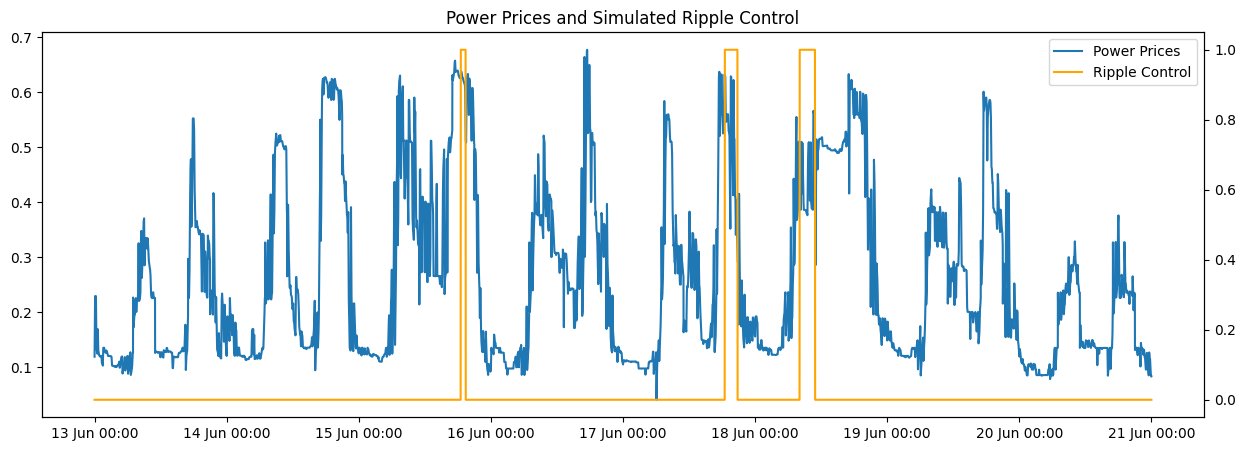

In [ ]:
# plot the power prices over a week in winter
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['2020-06-13':'2020-06-20'].cost, label='Power Prices')
ax2 = ax.twinx()
ax2.plot(df['2020-06-13':'2020-06-20'].ripple_control, color = 'orange',label='Ripple Control')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %H:%M'))
# show both legends on the same plot
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0)
# ax.legend()
ax.set_title('Power Prices and Simulated Ripple Control')
plt.show()

One simple potential methodology for pricing is to rank the current price of electricity relative to the upcoming x hours. Two of the foreward price ranked calculations are shown on the following graph. With the historical dataset it is possible to calculate this exactly however the forward pricing is a fundamental part of the electricity market so it is possible to make this calculation with high certainty using available data. The time of use rate portion of the cost also has a significant impact that generally pushes the price at peak times into a higher rank independent of the wholesale pricing. 

The [NZ Market Prices](https://www.electricityinfo.co.nz/prices#!#q.run_types_=A&q.market_types_=E&q.nodes_=PEN0331&q.main_date_or_rolling_selector=rolling&q.tp_roll_back=1&q.tp_roll_fwd=18&v.search_include=&v.search_exclude=) provides an example of the forward variability as an example.

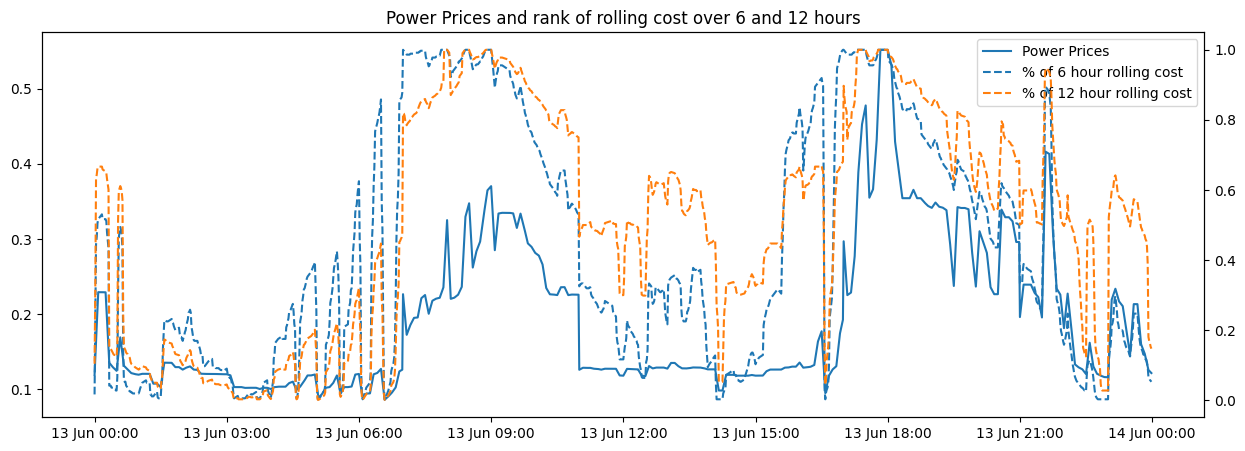

In [ ]:
# plot the power prices over a week in winter
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df.loc['2020-06-13'].cost, label='Power Prices')
ax2 = ax.twinx()
# ax2.plot(df['2020-06-13'].ripple_control, color = 'orange',label='Ripple Control')
ax2.plot(df.loc['2020-06-13'].costrank_6h, label='% of 6 hour rolling cost', ls='--')
ax2.plot(df.loc['2020-06-13'].costrank_12h, label='% of 12 hour rolling cost', ls='--')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %H:%M'))
# show both legends on the same plot
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0)
# ax.legend()
ax.set_title('Power Prices and rank of rolling cost over 6 and 12 hours')
plt.show()